# Comparative analysis of structural, learned, and hybrid feature representations for graph clustering

##### Final "Learning From Networks" course project
##### Authors: Chiara Frizzarin, Leonardo Gusson, Luca Rao
##### Date: 16/01/2026

---
## Notebook configuration

Use the following configuration cell to control the notebook's execution behavior.

By default, the `RECOMPUTE_*` flags are set to `False` to load pre-calculated results included in the repository at
`../data/processed/`.
The `DEVICE` parameter determines whether computations run on the CPU or GPU for functions that support acceleration.

In [41]:
import os
from pathlib import Path

DATA_DIR = Path("../data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

INPUT_DATA_PATH = DATA_DIR / "amazon-meta.txt"
PICKLE_PATH = PROCESSED_DATA_DIR / "amazon_graph.pickle"
HARMSCORE_PATH = PROCESSED_DATA_DIR / "harmonic_scores.csv"
BETSCORE_PATH = PROCESSED_DATA_DIR / "bet_scores.csv"
CLUSSCORE_PATH = PROCESSED_DATA_DIR / "clus_scores.csv"
PRSCORE_PATH = PROCESSED_DATA_DIR / "pagerank_scores.csv"
EMBEDDINGS_PATH = PROCESSED_DATA_DIR / "embeddings_p1_q2.csv"
RED_EMBEDDINGS_PATH = PROCESSED_DATA_DIR / "embeddings_p1_q2_reduced.csv"

class Config:
    DEVICE = "cuda"     # options: "cpu", "cuda"
    USE_HANDMADE_IMPLEMENTATIONS = True

    RECOMPUTE_DATA_PROCESSING = False
    RECOMPUTE_HARMONIC_CENTRALITY = False       # has 'cpu' and 'cuda' versions, both hand-made implementations
    RECOMPUTE_BETWEENNESS_CENTRALITY = False    # has nx library and hand-made versions, both run on cpu
    RECOMPUTE_CLUSTERING_COEFFICIENT = False    # has nx library and hand-made versions, both run on cpu
    RECOMPUTE_PAGERANK = False                  # has 'cpu' and 'cuda' versions, both hand-made implementations

    RECOMPUTE_EMBEDDINGS = False                # has 'cpu' and 'cuda' versions, both hand-made implementations
    REAPPLY_UMAP = False

config = Config()

---
## Common imports

In [42]:
import sys
import time
import numpy as np
import pandas as pd
import hashlib
import re
import gc

import pickle
import networkx as nx

import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize

# other dependencies...

if  config.RECOMPUTE_HARMONIC_CENTRALITY and config.DEVICE == 'cuda':
    import cupy as cp

if  config.RECOMPUTE_EMBEDDINGS and config.DEVICE == 'cpu':
    from node2vec import Node2Vec
    import umap

if  config.RECOMPUTE_EMBEDDINGS and config.DEVICE == 'cuda':
    import torch
    from torch_geometric.nn import Node2Vec as torch_Node2Vec
    from torch_geometric.utils import from_networkx
    import umap

sys.path.append(os.path.abspath('..'))

## Clustering flag

In [43]:
# Options: 'kmeans', 'gmm'
CLUSTERING_ALGORITHM = 'gmm'

---
## Data processing

In [44]:
from src import create_graph_pickle

if config.RECOMPUTE_DATA_PROCESSING:
    start_time = time.time()
    create_graph_pickle(INPUT_DATA_PATH, PICKLE_PATH)
    elapsed = time.time() - start_time
    print(f"Data processing completed in {elapsed:.2f} seconds.")

# Load the input graph from the pickle file
with open(PICKLE_PATH, "rb") as f:
    G = pickle.load(f)

print("Graph loaded")

Graph loaded


---
---
# A. Structural Features + SalesRank + Review Score

## Phase 1 : Building Feature Vectors

#### Harmonic centrality

In [45]:
from src import load_or_compute
from src.features import get_harmonic_centrality


start_time = time.time()

df_harmonic_scores = load_or_compute(
    HARMSCORE_PATH,
    get_harmonic_centrality,
    config.RECOMPUTE_HARMONIC_CENTRALITY,
    G=G,
    p=10,
    version=config.DEVICE
)
display(df_harmonic_scores.head(5))

elapsed = time.time() - start_time
print(
    f"Harmonic centrality "
    f"{'recomputed' if config.RECOMPUTE_HARMONIC_CENTRALITY else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,ASIN,HarmonicCentrality
0,0827229534,10890.978000
1,0738700797,9056.977000
2,0842328327,2.840921
3,1577943082,5.111011
4,0486220125,0.000000


Harmonic centrality loaded in 0.23 seconds.


#### Betweenness Centrality

In [46]:
from src import load_or_compute
from src.features import get_approx_betweenness


start_time = time.time()

df_bet = load_or_compute(
    BETSCORE_PATH,
    get_approx_betweenness,
    config.RECOMPUTE_BETWEENNESS_CENTRALITY,
    G=G,
    k=1000
)
display(df_bet.head(5))

elapsed = time.time() - start_time
print(
    f"Betweenness centrality "
    f"{'recomputed' if config.RECOMPUTE_BETWEENNESS_CENTRALITY else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,Betweenness
ASIN,
0827229534,0.0
0738700797,0.0
0842328327,0.0
1577943082,0.0
0486220125,0.0


Betweenness centrality loaded in 0.20 seconds.


#### PageRank

In [47]:
from src import load_or_compute
from src.features import get_pagerank


start_time = time.time()

df_pagerank = load_or_compute(
    PRSCORE_PATH,
    get_pagerank,
    config.RECOMPUTE_PAGERANK,
    G=G,
    force_cpu=(config.DEVICE == 'cpu')
)
display(df_pagerank.head(5))

elapsed = time.time() - start_time
print(
    f"Page Rank "
    f"{'recomputed' if config.RECOMPUTE_PAGERANK else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,pagerank
ASIN,
0827229534,5.332977e-06
0738700797,9.438284e-06
0842328327,6.925232e-07
1577943082,1.400741e-06
0486220125,4.671820e-07


Page Rank loaded in 0.25 seconds.


#### Clustering Coefficient

In [48]:
from src import load_or_compute
from src.features import get_clustering_coefficient

start_time = time.time()

df_clus = load_or_compute(
    CLUSSCORE_PATH,
    get_clustering_coefficient,
    config.RECOMPUTE_CLUSTERING_COEFFICIENT,
    G=G
)
display(df_clus.head(5))

elapsed = time.time() - start_time
print(
    f"Clustering coefficient "
    f"{'recomputed' if config.RECOMPUTE_CLUSTERING_COEFFICIENT else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.


,ClusteringCoefficient
ASIN,
0827229534,0.181818
0738700797,0.269231
0842328327,0.366667
1577943082,0.500000
0486220125,0.250000


Clustering coefficient loaded in 0.21 seconds.


### => Structural Features Vector

In [49]:
struct_df = [df_pagerank,df_clus,df_bet,df_harmonic_scores]
for df in struct_df:
    if 'ASIN' in df.columns:
        df.set_index('ASIN', inplace=True)
    # If the index is already ASIN but not named, rename it for clarity
    df.index.name = 'ASIN'
df_final = pd.concat(struct_df,axis=1, join='inner')

In [50]:
display(df_final)

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality
ASIN,,,,
0827229534,5.332977e-06,0.181818,0.0,10890.978000
0738700797,9.438284e-06,0.269231,0.0,9056.977000
0842328327,6.925232e-07,0.366667,0.0,2.840921
1577943082,1.400741e-06,0.500000,0.0,5.111011
0486220125,4.671820e-07,0.250000,0.0,0.000000
...,...,...,...,...
B00008MNUJ,4.671820e-07,0.166667,0.0,0.000000
0060537612,4.671820e-07,0.200000,0.0,0.000000
B00006JBIX,4.671820e-07,0.000000,0.0,0.000000


#### SalesRank Score

In [51]:
salesrank_dict = nx.get_node_attributes(G, 'salesrank')

# Convert to DataFrame
df_salesrank = pd.DataFrame.from_dict(salesrank_dict, orient='index', columns=['salesrank'])
df_salesrank.index.name = 'ASIN'

display(df_salesrank)

# Join to df_final
df_final = df_final.join(df_salesrank)

# Check the result
display(df_final.head())

,salesrank
ASIN,
0827229534,396585
0738700797,168596
0842328327,631289
1577943082,455160
0486220125,188784
...,...
B00008MNUJ,0
0060537612,0
B00006JBIX,0


,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank
ASIN,,,,,
0827229534,5.332977e-06,0.181818,0.0,10890.978000,396585.0
0738700797,9.438284e-06,0.269231,0.0,9056.977000,168596.0
0842328327,6.925232e-07,0.366667,0.0,2.840921,631289.0
1577943082,1.400741e-06,0.500000,0.0,5.111011,455160.0
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0


#### Review Scores
In this case we need to use the merge intead of join because the score reviews are computed on the whole dataset instead of the LCC and so we need to ensure that only scores with the same ASIN are added

In [52]:
df_review = pd.read_csv("../data/processed/review_scores.csv")
df_review.set_index("ASIN", inplace=True)
df_review.head()

,rw_score,num_reviews
ASIN,,
0827229534,5.000000,2
0738700797,4.136364,12
0486287785,5.000000,1
0842328327,4.000000,1
1577943082,2.500000,0


### => Structural Features + sr + rw Vector

In [53]:
df_final = pd.merge(df_final, 
    df_review[['rw_score']], 
    on='ASIN', how='left')

In [54]:
#TODO sometimes in rw_Score Nan are present 
df_final = df_final.fillna(0)
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,rw_score
ASIN,,,,,,
0827229534,5.332977e-06,0.181818,0.0,10890.978000,396585.0,5.000000
0738700797,9.438284e-06,0.269231,0.0,9056.977000,168596.0,4.136364
0842328327,6.925232e-07,0.366667,0.0,2.840921,631289.0,4.000000
1577943082,1.400741e-06,0.500000,0.0,5.111011,455160.0,2.500000
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,4.550296


In [55]:
df_final.to_csv("../data/processed/structural_metrics.csv")

### Normalization

1. Salesrank in logarithmic scale

In [56]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_final['salesrank_log'] = np.log1p(df_final['salesrank'])
features = ['pagerank','Betweenness','ClusteringCoefficient','HarmonicCentrality','salesrank_log','rw_score']
X=df_final[features]

#non ci dovrebbero essere NaN ma per sicurezza
X=X.fillna(0)

X.head()

,pagerank,Betweenness,ClusteringCoefficient,HarmonicCentrality,salesrank_log,rw_score
ASIN,,,,,,
0827229534,5.332977e-06,0.0,0.181818,10890.978000,12.890648,5.000000
0738700797,9.438284e-06,0.0,0.269231,9056.977000,12.035267,4.136364
0842328327,6.925232e-07,0.0,0.366667,2.840921,13.355521,4.000000
1577943082,1.400741e-06,0.0,0.500000,5.111011,13.028406,2.500000
0486220125,4.671820e-07,0.0,0.250000,0.000000,12.148364,4.550296


2. Z-score: setting mean around 0 and variance around 1 for every element of the vector

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features) # to check mean and variance of std data

print("Mean of scaled structural features:")
print(df_scaled.mean())
print("Std of scaled structural features:")
print(df_scaled.std())

Mean of scaled structural features:
pagerank                 1.358091e-18
Betweenness             -1.358091e-18
ClusteringCoefficient    5.500270e-17
HarmonicCentrality      -2.498888e-16
salesrank_log            2.053434e-15
rw_score                 4.390030e-16
dtype: float64
Std of scaled structural features:
pagerank                 1.000001
Betweenness              1.000001
ClusteringCoefficient    1.000001
HarmonicCentrality       1.000001
salesrank_log            1.000001
rw_score                 1.000001
dtype: float64


## Phase 2 : Clustering

We initialize only here the clustering method

In [58]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

if CLUSTERING_ALGORITHM == 'kmeans':
    model = KMeans(n_clusters=4, random_state=42, n_init=10)
    
elif CLUSTERING_ALGORITHM == 'gmm':
    model = GaussianMixture(n_components=4, random_state=42, n_init=1)
    
else:
    raise ValueError(f"unknown alg: {CLUSTERING_ALGORITHM}, check flag at the beginning of the notebook")

In [59]:
clusters = model.fit_predict(X_scaled)

df_final['cluster_kmeans'] = clusters

#questo stampa quanti nodi per ogni gruppo
print(df_final['cluster_kmeans'].value_counts())

#maybe we can save it

cluster_kmeans
0    122063
1    118358
3     87266
2      7156
Name: count, dtype: int64


In [60]:
#aggiungo il gruppo 
groups_dict = nx.get_node_attributes(G, 'group')

# 2. Converti in un DataFrame (assicurandoti che l'indice sia l'ASIN)
df_groups = pd.DataFrame.from_dict(groups_dict, orient='index', columns=['group'])
df_groups.index.name = 'ASIN'

# Remove 'group' from node attributes if it exists to avoid conflict
if 'group' in df_final.columns:
    df_final = df_final.drop(columns=['group'])

# join è intelligente: allinea automaticamente gli indici (ASIN)
df_final = df_final.join(df_groups)

In [61]:
import seaborn as sns 
import matplotlib.pyplot as plt

crosstab = pd.crosstab(df_final['cluster_kmeans'], df_final['group'])

print(crosstab)

group            Book   DVD  Music  Video
cluster_kmeans                           
0               95374  4620  11936  10133
1               80339  5881  28330   3808
2                5552   774    766     64
3               67651  4468  13792   1355


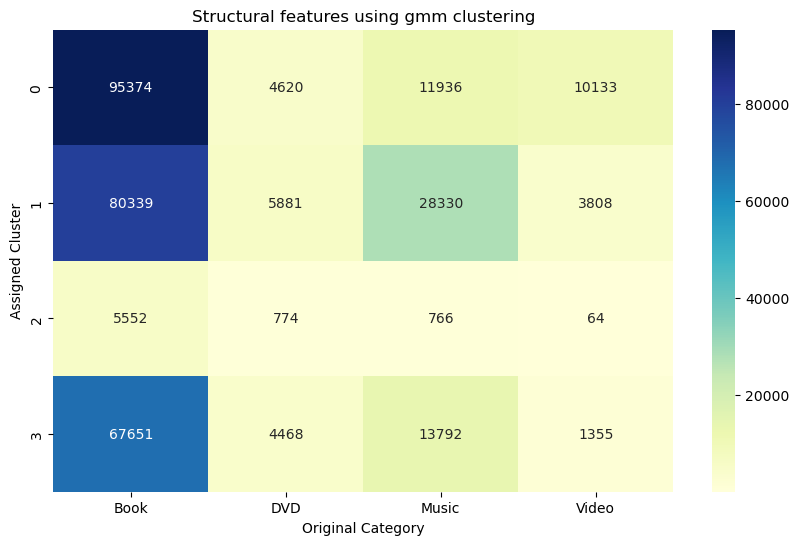

In [62]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.title('Structural features using '+CLUSTERING_ALGORITHM + ' clustering' )
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

## Phase 3 : Calculating NMI

In [63]:
import pandas as pd

RESULTS_FILE = "../data/results/clustering_results.csv"

In [64]:
from sklearn.metrics import normalized_mutual_info_score
from src.utils import log_clustering_results

df_eval_struct = df_final.dropna(subset=['group', 'cluster_kmeans'])

nmi_struct = normalized_mutual_info_score(df_eval_struct['group'], df_eval_struct['cluster_kmeans'])

print(f"Normalized Mutual Information (NMI): {nmi_struct:.4f}")

log_clustering_results("Structural", nmi_struct, overwrite=True)

Normalized Mutual Information (NMI): 0.0235
Clustering results for Structural saved correctly.


---
# B. Embeddings Features

## Phase 1 : Building Feature Vectors

In [65]:
from src import load_or_compute
from src.features import get_node2vec_embeddings, apply_umap

start_time = time.time()

df_embeddings = load_or_compute(
    EMBEDDINGS_PATH,
    get_node2vec_embeddings,
    config.RECOMPUTE_EMBEDDINGS,
    G=G,
    p=1,
    q=2,
    version=config.DEVICE,
)

df_embeddings = load_or_compute(
    RED_EMBEDDINGS_PATH,
    apply_umap,
    config.REAPPLY_UMAP,
    df_embeddings=df_embeddings
    #umap_metric = 'cosine', 'euclidean'
)

elapsed = time.time() - start_time
print(
    f"Embeddings "
    f"{'recomputed' if config.RECOMPUTE_EMBEDDINGS else 'loaded'} "
    f"in {elapsed:.2f} seconds."
)

File found.
File found.
Embeddings loaded in 6.88 seconds.


### Normalization

In [66]:
from sklearn.preprocessing import StandardScaler, normalize
df_embeddings.set_index('ASIN', inplace= True)
X = df_embeddings.values

In [67]:
X_norm = normalize(X)

print("Mean of scaled structural features:")
print(df_embeddings.mean())
print("Std of scaled structural features:")
print(df_embeddings.std())

Mean of scaled structural features:
umap_0    -0.187927
umap_1    10.009348
umap_2    -0.199030
umap_3    10.570980
umap_4     0.230288
umap_5    10.785931
umap_6    -0.534818
umap_7    10.507787
umap_8    -0.278695
umap_9    10.338595
dtype: float64
Std of scaled structural features:
umap_0    0.750183
umap_1    0.684033
umap_2    0.733775
umap_3    0.787041
umap_4    0.786289
umap_5    0.775285
umap_6    0.758794
umap_7    0.703747
umap_8    0.761941
umap_9    0.705856
dtype: float64


## Phase 2 : Clustering

In [68]:
#kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = model.fit_predict(X_norm)

df_embeddings['cluster_kmeans'] = clusters

print("\nCount of clusters:")
print(df_embeddings['cluster_kmeans'].value_counts())


Count of clusters:
cluster_kmeans
3    155713
2    113947
1     47379
0     17804
Name: count, dtype: int64


In [69]:
df_final = df_final.join(df_embeddings['cluster_kmeans'], rsuffix='_emb')
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,rw_score,salesrank_log,cluster_kmeans,group,cluster_kmeans_emb
ASIN,,,,,,,,,,
0827229534,5.332977e-06,0.181818,0.0,10890.978000,396585.0,5.000000,12.890648,3,Book,3
0738700797,9.438284e-06,0.269231,0.0,9056.977000,168596.0,4.136364,12.035267,3,Book,2
0842328327,6.925232e-07,0.366667,0.0,2.840921,631289.0,4.000000,13.355521,1,Book,3
1577943082,1.400741e-06,0.500000,0.0,5.111011,455160.0,2.500000,13.028406,1,Book,2
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,4.550296,12.148364,0,Book,2


In [70]:
crosstab = pd.crosstab(df_final['cluster_kmeans_emb'], df_final['group'])

print(crosstab)

group                 Book    DVD  Music  Video
cluster_kmeans_emb                             
0                    16899    175    263    467
1                    47078     47    125    129
2                    70793   4228  35944   2982
3                   114146  11293  18492  11782


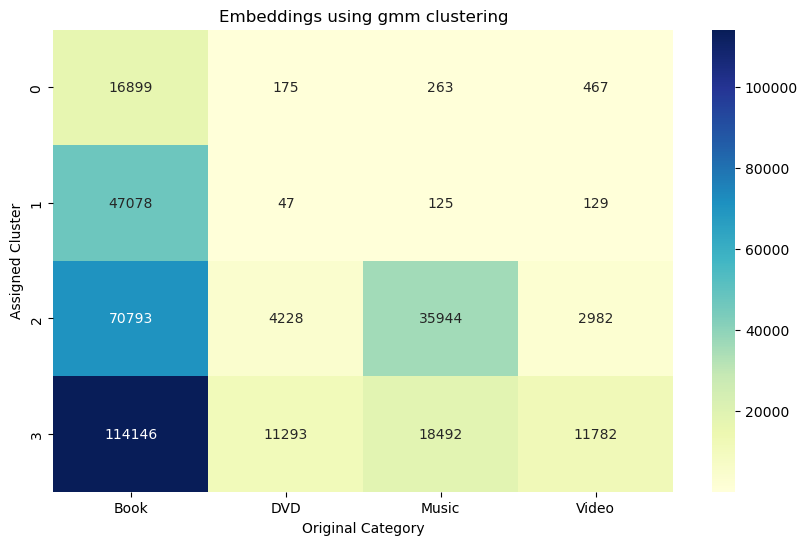

In [71]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.title('Embeddings using '+CLUSTERING_ALGORITHM + ' clustering' )
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

## Phase 3 : Calculating NMI

In [72]:
df_eval_emb = df_final.dropna(subset=['group', 'cluster_kmeans_emb'])

nmi_emb = normalized_mutual_info_score(df_eval_emb['group'], df_eval_emb['cluster_kmeans_emb'])

print(f"Normalized Mutual Information (NMI): {nmi_emb:.4f}")

log_clustering_results("Learned (Embeddings)", nmi_emb, overwrite=False)

Normalized Mutual Information (NMI): 0.0824
Clustering results for Learned (Embeddings) saved correctly.


---
## C. Hybrid Features

## Phase 1 : Building Feature Vectors

In [73]:
# Use again salsrank in logarithmic scale
df_salesrank['salesrank_log'] = np.log1p(df_salesrank['salesrank'])

data_frames = [df_pagerank,df_clus,df_bet,df_harmonic_scores,df_salesrank[['salesrank_log']]]

df_struct = pd.concat(data_frames,axis=1)

In [74]:
df_struct = pd.merge(df_struct, 
    df_review[['rw_score']], 
    on='ASIN', how='left')

In [75]:
df_struct = df_struct.fillna(0)
df_struct.head(10)

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank_log,rw_score
ASIN,,,,,,
0827229534,5.332977e-06,0.181818,0.0,10890.978000,12.890648,5.000000
0738700797,9.438284e-06,0.269231,0.0,9056.977000,12.035267,4.136364
0842328327,6.925232e-07,0.366667,0.0,2.840921,13.355521,4.000000
1577943082,1.400741e-06,0.500000,0.0,5.111011,13.028406,2.500000
0486220125,4.671820e-07,0.250000,0.0,0.000000,12.148364,4.550296
B00000AU3R,5.403461e-06,0.133333,0.0,9.548288,8.592857,4.944444
0231118597,3.781384e-06,0.083333,0.0,11346.124000,12.533252,4.740385
0375709363,4.671820e-07,0.600000,0.0,0.000000,12.303109,4.027778
0871318237,4.671820e-07,0.166667,0.0,0.000000,12.931113,5.000000


In [76]:
df_hybrid_raw = df_struct.join(df_embeddings, how='inner', lsuffix='_struct', rsuffix='_umap')

# Identify columns
cols_struct = [c for c in df_struct.columns if c not in ['group', 'title', 'ASIN', 'salesrank']]
cols_emb = [c for c in df_embeddings.columns if c not in ['group', 'title', 'ASIN']]

print(f"Structural features (Centralità + Salesrank_log): {len(cols_struct)}")
print(f"Embedding dimensions: {len(cols_emb)}")
print(f"Total aligned nodes: {len(df_hybrid_raw)}")

Structural features (Centralità + Salesrank_log): 6
Embedding dimensions: 11
Total aligned nodes: 334843


In [77]:
display(df_hybrid_raw)

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank_log,rw_score,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8,umap_9,cluster_kmeans
ASIN,,,,,,,,,,,,,,,,,
0827229534,5.332977e-06,0.181818,0.0,10890.978000,12.890648,5.000000,-0.398756,8.925066,-1.515206,9.580088,0.044865,9.742376,-1.332156,11.504207,-1.104812,8.931296,3
0738700797,9.438284e-06,0.269231,0.0,9056.977000,12.035267,4.136364,-0.450911,10.184773,0.213566,9.834129,0.671659,8.764313,-0.779994,10.205864,-1.374801,9.593761,2
0842328327,6.925232e-07,0.366667,0.0,2.840921,13.355521,4.000000,-0.198836,10.037330,-0.110328,10.453698,0.344686,10.848904,-0.630023,10.575796,-0.520771,10.551919,3
1577943082,1.400741e-06,0.500000,0.0,5.111011,13.028406,2.500000,-0.712520,9.642870,1.628876,10.287208,-0.125029,10.805843,0.087487,11.639998,-1.082957,9.808597,2
0486220125,4.671820e-07,0.250000,0.0,0.000000,12.148364,4.550296,1.147409,9.363758,0.265252,10.387319,-0.109889,9.118997,-1.543635,9.500496,-0.516680,10.328959,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00008MNUJ,4.671820e-07,0.166667,0.0,0.000000,0.000000,4.612903,0.042786,10.403842,0.070690,10.440588,0.317981,10.861651,-0.960352,10.652198,-0.278659,9.996120,3
0060537612,4.671820e-07,0.200000,0.0,0.000000,0.000000,5.000000,-1.082269,8.747138,0.003196,9.970079,-0.093321,11.410872,-0.446270,10.946393,-0.494133,11.200259,0
B00006JBIX,4.671820e-07,0.000000,0.0,0.000000,0.000000,1.666667,0.278983,10.118343,-0.837042,10.925252,1.072966,10.716864,0.007092,9.927563,-0.778191,10.423711,2


### Normalization

1. Z-score: setting mean around 0 and variance around lambda_weight for every element of the vector

In [78]:
# Standardize structural features (Z-score)
scaler = StandardScaler()
X_struct_scaled = scaler.fit_transform(df_hybrid_raw[cols_struct].fillna(0))

# Normalize embedding features (L2 norm)
X_emb_norm = normalize(df_hybrid_raw[cols_emb].fillna(0))

# Compute weight
lambda_weight = np.sqrt(len(cols_emb) / len(cols_struct))

# Combine features
X_struct_weighted = X_struct_scaled * lambda_weight
X_hybrid_balanced = np.hstack((X_struct_weighted, X_emb_norm))

In [79]:
# Create final DataFrame
df_hybrid_features = pd.DataFrame(
    X_hybrid_balanced, 
    index=df_hybrid_raw.index, 
    columns=list(cols_struct) + list(cols_emb)
)

display(df_hybrid_features.head())

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank_log,rw_score,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8,umap_9,cluster_kmeans
ASIN,,,,,,,,,,,,,,,,,
0827229534,0.460340,-0.158088,-0.143552,2.766431,0.950935,1.345896,-0.017961,0.401999,-0.068247,0.431502,0.002021,0.438812,-0.060002,0.518168,-0.049762,0.402280,0.135125
0738700797,1.251074,0.438921,-0.143552,2.162653,0.177014,0.090944,-0.020567,0.464554,0.009741,0.448560,0.030636,0.399763,-0.035578,0.465516,-0.062708,0.437596,0.091225
0842328327,-0.433469,1.104387,-0.143552,-0.818095,1.371536,-0.107206,-0.008397,0.423869,-0.004659,0.441452,0.014556,0.458141,-0.026605,0.446608,-0.021992,0.445599,0.126688
1577943082,-0.297057,2.015025,-0.143552,-0.817347,1.075574,-2.286859,-0.030228,0.409084,0.069103,0.436419,-0.005304,0.458421,0.003712,0.493809,-0.045943,0.416115,0.084847
0486220125,-0.476872,0.307579,-0.143552,-0.819030,0.279341,0.692430,0.052170,0.425745,0.012060,0.472284,-0.004996,0.414616,-0.070185,0.431962,-0.023492,0.469630,0.090935


In [80]:
print("Mean of scaled structural features:")
print(df_hybrid_features[cols_struct].mean())
print("Std of scaled structural features:")
print(df_hybrid_features[cols_struct].std())

Mean of scaled structural features:
pagerank                -2.308755e-17
ClusteringCoefficient    4.889129e-17
Betweenness             -2.308755e-17
HarmonicCentrality      -3.198305e-16
salesrank_log            2.770506e-15
rw_score                 6.057087e-16
dtype: float64
Std of scaled structural features:
pagerank                 1.354008
ClusteringCoefficient    1.354008
Betweenness              1.354008
HarmonicCentrality       1.354008
salesrank_log            1.354008
rw_score                 1.354008
dtype: float64


## Phase 2 : Clustering

In [81]:
#kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = model.fit_predict(df_hybrid_features)

# Aggiungiamo i cluster al df originale per analisi
#df_results = df_hybrid_raw.copy()
df_final.loc[df_hybrid_raw.index, 'cluster_hybrid'] = clusters

if 'group' in df_final.columns:
    print("\nComparison with Ground Truth:")
    print(pd.crosstab(df_final['cluster_hybrid'], df_final['group']))


Comparison with Ground Truth:
group             Book   DVD  Music  Video
cluster_hybrid                            
0.0              19895   133    720    183
1.0              98828  7376  35988   3373
2.0             124018  7360  17390  11740
3.0               6175   874    726     64


In [82]:
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,rw_score,salesrank_log,cluster_kmeans,group,cluster_kmeans_emb,cluster_hybrid
ASIN,,,,,,,,,,,
0827229534,5.332977e-06,0.181818,0.0,10890.978000,396585.0,5.000000,12.890648,3,Book,3,1.0
0738700797,9.438284e-06,0.269231,0.0,9056.977000,168596.0,4.136364,12.035267,3,Book,2,1.0
0842328327,6.925232e-07,0.366667,0.0,2.840921,631289.0,4.000000,13.355521,1,Book,3,2.0
1577943082,1.400741e-06,0.500000,0.0,5.111011,455160.0,2.500000,13.028406,1,Book,2,0.0
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,4.550296,12.148364,0,Book,2,1.0


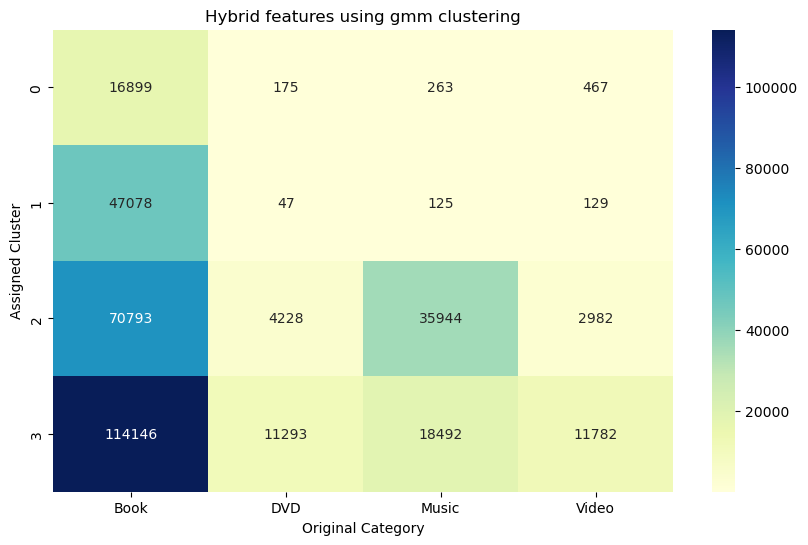

In [83]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.title('Hybrid features using '+CLUSTERING_ALGORITHM + ' clustering' )
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

## Phase 3 : Calculating NMI

In [84]:
df_eval_hybrid = df_final.dropna(subset=['group', 'cluster_hybrid'])

nmi_hybrid = normalized_mutual_info_score(df_eval_hybrid['group'], df_eval_hybrid['cluster_hybrid'])

print(f"Normalized Mutual Information (NMI): {nmi_hybrid:.4f}")

log_clustering_results("Hybrid", nmi_hybrid)

Normalized Mutual Information (NMI): 0.0363
Clustering results for Hybrid saved correctly.


---
---
# Results

### Original Categories Plotting

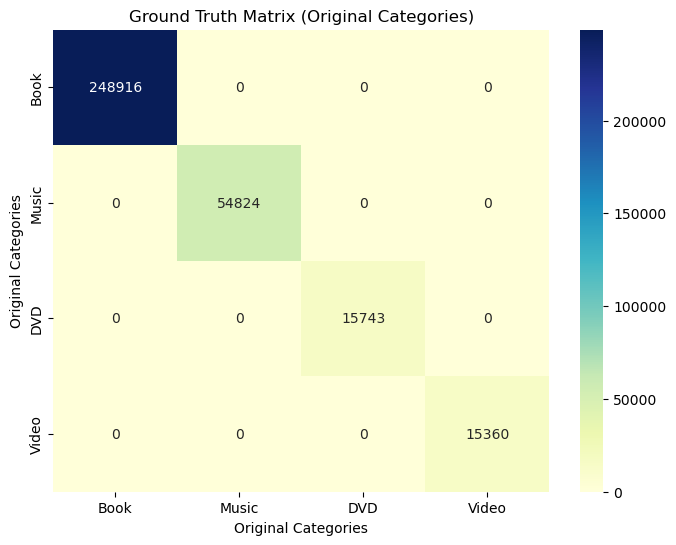

In [85]:
# Original clustering
# Print the original clustering figure

# Extract ground truth groups from the graph
groups_dict = nx.get_node_attributes(G, 'group')
groups_series = pd.Series(groups_dict)

# Count occurrences of each category
counts = groups_series.value_counts()
categories = counts.index.tolist()

# Make an empty confusion matrix
gt_matrix = pd.DataFrame(0, index=categories, columns=categories)

# Fill the diagonal with the real counts
for cat in categories:
    gt_matrix.loc[cat, cat] = counts[cat]

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(gt_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Ground Truth Matrix (Original Categories)')
plt.xlabel('Original Categories')
plt.ylabel('Original Categories')
plt.show()

SUMMARY:


,NMI
method,
Hybrid,0.0363
Learned (Embeddings),0.0824
Structural,0.0235


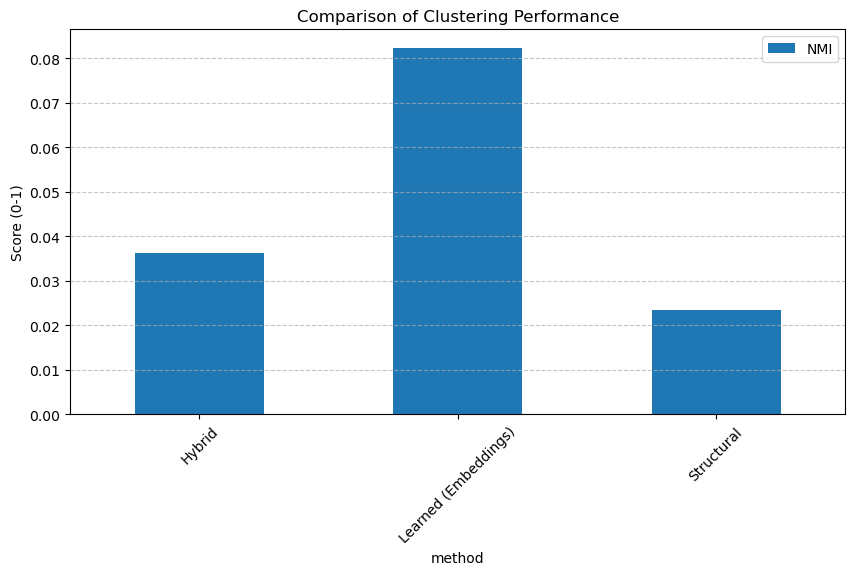

In [86]:
# Upload results
df_results = pd.read_csv(RESULTS_FILE)

# Group them by
summary = df_results.groupby('method')[['NMI']].first()

# Print table for comparisons
print("SUMMARY:")
display(summary)

# Plot
summary.plot(kind='bar', figsize=(10, 5))
plt.title("Comparison of Clustering Performance")
plt.ylabel("Score (0-1)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()